# Code to generate jitter sequence for visual stimuli in mice 

## Reference: Payne & Raymond (2017).

## Import modules & functions

In [192]:
import numpy as np
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt

In [193]:
def bessel_lowpass_filter(data, cutoff=1, fs=30.0, order=3):
    b_h, a_h = _bessel_lowpass(cutoff, fs, order=order)
    y_h = scipy.signal.filtfilt(b_h, a_h, data)
    return y_h

def _bessel_lowpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b_h, a_h = scipy.signal.bessel(order, normal_cutoff, btype='low', analog=False)
    return b_h, a_h

## Set parameters

In [194]:
DURATION = 600 # s
STD_EYE_POSITION_DEG = 10.0           # Payne & Raymond (2017).  1-axis
MEAN_EYE_SPEED_DEG_PER_S = 50.0       # Payne & Raymond (2017).  1-axis
PX_PER_DEG = 3.0 # 10 X bottom objective lens @ D213 upright scope
STIM_FREQUENCY = 30.0 # Hz
SEED_X = 0
SEED_Y = 2

## Generate sequence and lowpass filter

In [195]:
np.random.seed(0)
jit_raw = np.random.randn(int(DURATION*STIM_FREQUENCY)) # 600-s sequence of 30 Hz (visual stim. by DLP)
jit_raw -= np.mean(jit_raw)
jit_raw /= np.std(jit_raw)

In [196]:
search_l = 1
search_u = 4
search_num = 30
jit_lpf = np.zeros((search_num, jit_raw.shape[0]))
th_list = np.zeros(jit_lpf.shape[0])
for i, th in enumerate(np.linspace(search_l, search_u, search_num)):
    jit_lpf_temp = bessel_lowpass_filter(jit_raw, cutoff=th, fs=STIM_FREQUENCY, order=3)
    jit_lpf_temp -= np.mean(jit_lpf_temp)
    jit_lpf_temp /= np.std(jit_lpf_temp)
    jit_lpf_temp *= STD_EYE_POSITION_DEG
    jit_lpf[i, :] = jit_lpf_temp
    th_list[i] = th
    print(th)

1.0
1.103448275862069
1.206896551724138
1.3103448275862069
1.4137931034482758
1.5172413793103448
1.6206896551724137
1.7241379310344827
1.8275862068965516
1.9310344827586206
2.0344827586206895
2.137931034482759
2.2413793103448274
2.344827586206897
2.4482758620689653
2.5517241379310347
2.655172413793103
2.7586206896551726
2.862068965517241
2.9655172413793105
3.0689655172413794
3.1724137931034484
3.2758620689655173
3.3793103448275863
3.4827586206896552
3.586206896551724
3.689655172413793
3.793103448275862
3.896551724137931
4.0


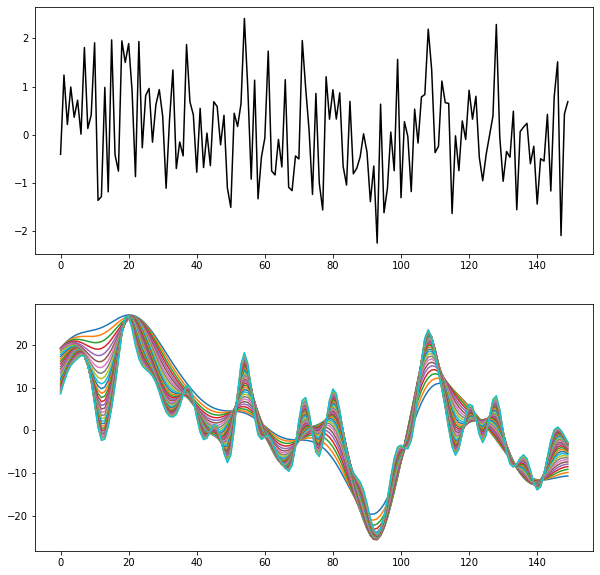

In [197]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(211)
ax.plot(jit_raw[90:240], 'k')
ax = plt.subplot(212)
ax.plot(jit_lpf[:, 90:240].T)

## Search mean eye speed for sequences with different cutoff frequence during lowpass filtering

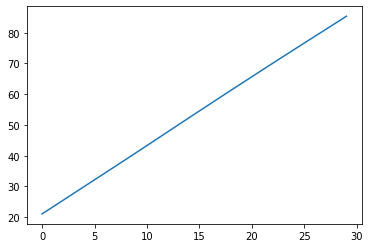

In [198]:
plt.plot(np.mean(abs(np.diff(jit_lpf, axis=1)/(1/STIM_FREQUENCY)), axis=1))

In [199]:
np.mean(abs(np.diff(jit_lpf, axis=1)/(1/STIM_FREQUENCY)), axis=1)[13]

50.0799216208641

In [200]:
cutoff = th_list[13]
th_list[13] # this cutoff frequence will be used 

2.344827586206897

## Generate x, y sequences with found cutoff frequency

In [201]:
np.random.seed(SEED_X)
jit_raw_x = np.random.randn(int(DURATION*STIM_FREQUENCY) + 30) # 600-s sequence of 30 Hz 
jit_raw_x -= np.mean(jit_raw_x)
jit_raw_x /= np.std(jit_raw_x)
np.random.seed(SEED_Y)
jit_raw_y = np.random.randn(int(DURATION*STIM_FREQUENCY) + 30) # 600-s sequence of 30 Hz 
jit_raw_y -= np.mean(jit_raw_y)
jit_raw_y /= np.std(jit_raw_y)

In [202]:
jit_lpf_x = bessel_lowpass_filter(jit_raw_x, cutoff=cutoff, fs=STIM_FREQUENCY, order=3)
jit_lpf_x -= np.mean(jit_lpf_x)
jit_lpf_x /= np.std(jit_lpf_x)
jit_lpf_x *= STD_EYE_POSITION_DEG
jit_lpf_y = bessel_lowpass_filter(jit_raw_y, cutoff=cutoff, fs=STIM_FREQUENCY, order=3)
jit_lpf_y -= np.mean(jit_lpf_y)
jit_lpf_y /= np.std(jit_lpf_y)
jit_lpf_y *= STD_EYE_POSITION_DEG

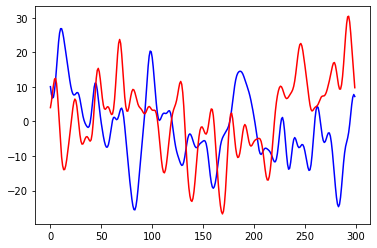

In [203]:
plt.plot(jit_lpf_x[100:400], 'b')
plt.plot(jit_lpf_y[100:400], 'r')

In [204]:
# check
print(np.mean(abs(np.diff(jit_lpf_x)/(1/STIM_FREQUENCY))), 
      np.mean(abs(np.diff(jit_lpf_y)/(1/STIM_FREQUENCY))))

50.091099631333236 49.95361932565266


In [205]:
jit_lpf_x.shape, jit_lpf_y.shape

((18030,), (18030,))

In [206]:
jit_lpf = np.vstack([jit_lpf_x[30:], jit_lpf_y[30:]])
jit_lpf.shape

(2, 18000)

## Save as *.mat file

In [207]:
#scipy.io.savemat("jitter.mat", {"jitter":jit_lpf})